In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pythonlib.tools.stroketools import strokesInterpolate2, strokesFilter, smoothStrokes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.optimize import minimize_scalar, minimize

plt.style.use('dark_background')

In [24]:
with open("/home/danhan/freiwaldDrive/dhanuska/230126_pancho_proc_data.pkl", 'rb') as f:
    dfs = pickle.load(f)

In [25]:
def fps(x, fs):
    '''Five point stentil function for discrete derivative, scales to m/s auto'''
    v = [(-x[i+2] + 8*x[i+1] - 8*x[i-1] + x[i-2])/12 for i in range(len(x)) if 2<=i<len(x)-2]
    return np.array(v) * fs
def fps2(x, fs):
    '''Same as above but for second derivative scales to m/s**2 auto'''
    a = [(-x[i+2] + 16*x[i+1] - 30*x[i] + 16*x[i-1] - x[i-2])/12 for i in range(len(x)) if 2<=i<len(x)-2]
    return np.array(a) * fs**2

In [23]:
trial_inds = [4,5,6,7]
for trial in trial_inds:
    dat = dfs[trial]["220914_f12_dlc"]
    strokes_cam = dat["reg_strokes_cam"]
    gaps_cam = dat["reg_gaps_cam"]
    strokes_touch = dat["strokes_touch"]

    num_strokes = len(strokes_touch)

    N = ["input_times"]
    for strok in strokes_cam:
        N.append(strok[:,3])
    touch_interp = strokesInterpolate2(strokes_touch,N)

    all_pos = np.concatenate((np.concatenate(strokes_cam),np.concatenate(gaps_cam)))
    all_pos = np.sort(all_pos)
    print(all_pos)

    vx = fps(all_pos[:,0])
    vy = fps(all_pos[:,1])
    vz = fps(all_pos[:,2])
    tv = all_pos[2:-2,3]
    ta = tv
    

    ax = fps2(all_pos[:,0])
    ay = fps2(all_pos[:,1])
    az = fps2(all_pos[:,2])

    

    fig, axe = plt.subplots(3,1,figsize=(20,10))
    fig.suptitle(f"Trial: {trial}")

    m=0
    color='cornflowerblue'
    axe[m].set_ylim(min(vx),max(vx))
    for strok in strokes_touch:
        axe[m].fill_between(strok[:,2], axe[m].get_ylim()[0], axe[m].get_ylim()[1], fc='grey',alpha=0.2)
    axe[m].scatter(ta,ax,label='ax', color='black')
    axe[m].scatter(tv,vx, label='vx', color=color)
    axe[m].legend()

    m=1
    color='sandybrown'
    axe[m].set_ylim(min(vy),max(vy))
    for strok in strokes_touch:
        axe[m].fill_between(strok[:,2], axe[m].get_ylim()[0], axe[m].get_ylim()[1], fc='grey',alpha=0.2)
    axe[m].scatter(ta,ay,label='ay',color='black')
    axe[m].scatter(tv,vy, label='vy', color=color)
    axe[m].legend()

    m=2
    color='darkseagreen'
    axe[m].set_ylim(min(az),max(az))
    for strok in strokes_touch:
        axe[m].fill_between(strok[:,2], axe[m].get_ylim()[0], axe[m].get_ylim()[1], fc='grey',alpha=0.2)
    axe[m].scatter(ta,az,label='az',color='black')
    axe[m].scatter(tv,vz, label='vz',color=color)
    axe[m].legend()

    az_t = np.column_stack((az,ta))
    sort_inds = np.argsort(az_t[:,0])
    top_vals = az_t[sort_inds[-num_strokes:]]
    

    for p in top_vals:
        axe[m].axvline(p[1])
    



    all_touch = np.concatenate(strokes_touch)
    axe[0].set_xlim(min(all_touch[:,2])-0.5)
    axe[1].set_xlim(min(all_touch[:,2])-0.5)
    axe[2].set_xlim(min(all_touch[:,2])-0.5)

    fig = plt.figure()
    plt.plot(all_pos[:,2], ".-")
    
    
    
    # trial_len = len(strokes_cam) + len(gaps_cam)

NameError: name 'dfs' is not defined

In [5]:
def max_dist_heuristic(x, mode):
    '''
    x, n,2 array with a value and a time
    target, target value to get close in this case a mean
    mode, onsets or offsets
    '''
    diffs = np.diff(np.diff(x[:,0]))

    if mode == 'on':
        #Return pt who has biggest difference from previous
        return x[np.argmin(diffs)+1]
    elif mode == 'off':
        #Return pt who has biggest diff from next pt
        return x[np.argmin(diffs)]
    else:
        assert False, 'give mode on or off'
    
def on_off_heuristics(stroke_vs, stroke_as, wind, t, mode, window_size = 0.0008):

    if mode == 'on':
        vz_lb = np.mean(stroke_vs) - window_size
        az_ub = np.mean(stroke_as) + window_size
        az_lb = np.mean(stroke_as) - window_size
        above_lb = wind[:,0] >= vz_lb
        a_in_thresh = (wind[:,1] >= az_lb) & (wind[:,1] <= az_ub)
        above_lb_and_no_next_below = []

        #Make sure all following vs are in thresh
        next_val_true = True
        for val in reversed(above_lb):
            if not val:
                next_val_true = False
            above_lb_and_no_next_below.append(next_val_true)
        above_lb_and_no_next_below.reverse()

        #Maker sure all following as are in thresh
        next_val_true = True
        a_in_thresh_no_next_out = []
        for val in reversed(a_in_thresh):
            if not val:
                next_val_true = False
            a_in_thresh_no_next_out.append(next_val_true)
        a_in_thresh_no_next_out.reverse()

        prev_point_more_neg = wind[:,0] > np.roll(wind[:,0],1)
        both = above_lb_and_no_next_below & prev_point_more_neg & a_in_thresh_no_next_out
        both[0] = False
        filtered = wind[both]
        if len(filtered) == 0:
            return [-100,0,t]
        else:
            pt = filtered[filtered[:,2].argsort()][0]
            return pt
    elif mode == 'off':
        vz_ub = np.mean(stroke_vs) + window_size-0.0002
        under_ub = wind[:,0] <= vz_ub
        below_ub_and_no_prev_below = []
        prev_val_true = True
        for val in under_ub:
            if not val:
                prev_val_true = False
            below_ub_and_no_prev_below.append(prev_val_true)
        next_point_more_pos = wind[:,0] < np.roll(wind[:,0],-1)
        both = below_ub_and_no_prev_below & next_point_more_pos
        both[0] = False
        filtered = wind[both]
        if len(filtered) == 0:
            return [-100,0,t]
        else:
            pt = filtered[filtered[:,2].argsort()][-1]
            return pt
    else:
        assert False, 'give mode on or off'

In [78]:
#trial here is trial ml2/1 index btw
onset_pts = {}
offset_pts = {}
touch_ons = {}
touch_offs = {}
t_offset = {}
t_off_touch = {}
do_ts_average = True
search_window = 0.015
for trial,dat in dfs.items():
    onset_pts[trial-1] = []
    offset_pts[trial-1] = []
    fig = plt.figure(figsize=(40,15))
    dat = dat["220914_f12_dlc"]
    try:
        strokes_cam = dat["trans_strokes_cam"]
        gaps_cam = dat["trans_gaps_cam"]
        strokes_touch = dat["strokes_touch"]
    except:
        continue
    num_strokes = len(strokes_touch)
    end_last_stroke = max(strokes_touch[-2][:,2]) + 0.25
    all_touch = np.concatenate(strokes_touch)
    beg_first_stroke = min(all_touch[2:,2])-0.1
    all_gaps=np.concatenate(gaps_cam)
    t_offset[trial-1] = np.min(all_gaps[:,3])
    t_off_touch[trial-1] = np.min(all_touch[:,2])

    all_pos = np.concatenate((np.concatenate(strokes_cam),np.concatenate(gaps_cam)))
    all_pos = all_pos[all_pos[:,3].argsort()]
    all_pos = all_pos[(all_pos[:,3] >= beg_first_stroke) & (all_pos[:,3] <= end_last_stroke)]

    touch_fs = 1/np.mean(np.diff(np.concatenate(strokes_touch)[:,2]))
    cam_fs = 1/np.mean(np.diff(all_pos[:,3]))



    N = ["input_times"]
    for strok in strokes_cam:
        N.append(strok[:,3])
    touch_interp = strokesInterpolate2(strokes_touch,N)
    # strokes_touch = touch_interp

    kind='linear'
    strokes_cam_int = strokesInterpolate2(strokes_cam,kind=kind,N=["fsnew",1000,cam_fs])
    gaps_cam_int = strokesInterpolate2(gaps_cam,kind=kind,N=["fsnew",1000,cam_fs])
    strokes_gaps_all = np.concatenate((np.concatenate(gaps_cam),np.concatenate(strokes_cam)))
    strokes_gaps_int = strokesInterpolate2([all_pos],kind=kind,N=["fsnew",1000,cam_fs])[0]
    
    f1 = 8
    
    pz = all_pos[:,2]
    t = all_pos[:,3]
    vz = fps(pz, cam_fs)
    tv = t[2:-2]
    ta = tv

    stroke_vs = []
    stroke_as = []
    for i,strok in enumerate(strokes_cam):
        if i == 0 or i == len(strokes_cam)-1:
            continue
        v = fps(strok[:,2], cam_fs)
        a = fps2(strok[:,2], cam_fs)
        stroke_vs.append(np.column_stack((v,strok[2:-2,3])))
        stroke_as.append(np.column_stack((a,strok[2:-2,3])))
    

    gap_vs = []
    gap_as = []
    for i,gap in enumerate(gaps_cam):
        #No gaps that fall outisde of strokes
        if gap[0,3]<beg_first_stroke or gap[0,3]>end_last_stroke:
            continue
        v = fps(gap[:,2], cam_fs)
        a = fps2(gap[:,2], cam_fs)
        gap_vs.append(np.column_stack((v,gap[2:-2,3])))
        gap_as.append(np.column_stack((a,gap[2:-2,3])))
    
    stroke_vs_int = []
    stroke_as_int = []
    for i,strok in enumerate(strokes_cam_int):
        if i == 0 or i == len(strokes_cam_int)-1:
            continue
        v = fps(strok[:,2], cam_fs)
        a = fps2(strok[:,2], cam_fs)
        stroke_vs_int.append(np.column_stack((v,strok[2:-2,3])))
        stroke_as_int.append(np.column_stack((a,strok[2:-2,3])))
    

    gap_vs_int = []
    gap_as_int = []
    for i,gap in enumerate(gaps_cam_int):
        #No gaps that fall outisde of strokes
        if gap[0,3]<beg_first_stroke or gap[0,3]>end_last_stroke:
            continue
        v = fps(gap[:,2], cam_fs)
        a = fps2(gap[:,2], cam_fs)
        gap_vs_int.append(np.column_stack((v,gap[2:-2,3])))
        gap_as_int.append(np.column_stack((a,gap[2:-2,3])))

    all_v_int = fps(strokes_gaps_int[:,2],1000)
    all_t_int = strokes_gaps_int[2:-2,3]
    vt_int = np.column_stack((all_v_int,all_t_int))
    zt_int = np.column_stack((strokes_gaps_int[:,2],strokes_gaps_int[:,3])) 

    #Smooth z pos and format
    zpos_if = smoothStrokes([zt_int],1000, window_type='median')[0]
    stroke_ts = [(np.min(stroke[:,3]),np.max(stroke[:,3])) for stroke in strokes_cam]
    gap_ts = [(np.min(stroke[:,3]),np.max(stroke[:,3])) for stroke in gaps_cam]
    stroke_zs_if = []
    for tb, te in stroke_ts:
        stroke_zs_if.append(zpos_if[(zpos_if[:,1] >= tb) & (zpos_if[:,1] <= te)])
    gap_zs_if = []
    for tb, te in gap_ts:
        gap_zs_if.append(zpos_if[(zpos_if[:,1] >= tb) & (zpos_if[:,1] <= te)])
    
    #Smooth velocities and format
    strokes_gaps_if = smoothStrokes([vt_int],1000, window_type='median')[0]
    stroke_vs_if = []
    for tb, te in stroke_ts:
        stroke_vs_if.append(strokes_gaps_if[(strokes_gaps_if[:,1] >= tb) & (strokes_gaps_if[:,1] <= te)])
    gap_vs_if = []
    for tb, te in gap_ts:
        gap_vs_if.append(strokes_gaps_if[(strokes_gaps_if[:,1] >= tb) & (strokes_gaps_if[:,1] <= te)])
       
    
    
    ons = []
    offs = []
    for strok in strokes_touch:
        ons.append(strok[0,:])
        offs.append(strok[-1,:])
    ons = np.array(ons)
    offs = np.array(offs)

    plt.plot(zpos_if[:,1],zpos_if[:,0]*10, '.-',label='pz', color="chocolate")
    # plt.plot(all_t_int,all_v_int, label='vz_interp', color='darkseagreen')
    plt.plot(strokes_gaps_if[:,1],strokes_gaps_if[:,0], label='vz_filt', color = 'indianred')
    # plt.plot(tv,vz,'.-',label='vz', color="cornflowerblue")
    # plt.plot(ta,az,'.-',label='az',color="darkseagreen")
    # plt.scatter(tv,vz, label='vz',color=color)
    plt.xticks(np.linspace(min(t),max(t),20))

    time_window_size = 0.08
    space_window_size = 0.0008
    def exp_sat_model(t,a,b):
        return a*(1-np.exp(-b*t))
    def log_model(t,a,b):
        return a*np.log(b*t)
    
    touch_ons[trial-1] = []
    touch_offs[trial-1] = []
    
    

    #ONSETS
    #General approach here is to fit a linear trend from the min stroke v
    for gap in gap_vs_if:
        t=1 #ind for t coord
        z=0 #ind for vz coord
        if len(gap) == 0:
            continue
        if gap[0,t] < beg_first_stroke:
            continue
        next_stroke = None
        for stroke in stroke_vs_if:
            if len(stroke) == 0:
                continue
            if stroke[0,t] > gap[0,t]:
                #Get first stroke bigger than gap off
                next_stroke = stroke
                break
            else:
                continue
        if next_stroke is None:
            continue
        stroke=next_stroke

        #Touchscreen onset time this stroke
        ts_on = None
        for on in ons[:,2]:
            if on > gap[0,t]:
                #Get first ts onset bigger than gap on (in case ts triggers b4 stroke gap switch)
                ts_on = on
                break
            else:
                continue
        if ts_on is None:
            touch_ons[trial-1].append('NA')
            continue
        touch_ons[trial-1].append(ts_on)
        #Get window of times that are in bounds of given window size (i.e. expected error of ts data, ~4 frames=0.08s)
        t_window = gap[gap[:,t] >= ts_on-time_window_size]
        t_bounds = [np.min(t_window[:,t]),np.max(t_window[:,t])]

        #Restrict gap search to be just the period right before the stroke
        gap = gap[gap[:,t] > gap[-1,t] - search_window]


        #Accunmulate data
        
        gap_min_ind = np.argmin(gap[:,z])
        # gap_min_z = gap[gap_min_ind,z]
        gap_min_z = np.min(gap[:,z])
        gap_min_t = gap[gap_min_ind,t]
        pts = np.concatenate((gap[gap_min_ind:,:],stroke[:len(stroke)//2,:]))
        # pts = gap[gap_min_ind:,:]
        x_all = pts[:,1]
        y_all = pts[:,0]
        x_adj = x_all-np.min(x_all)


        def oneLine(t,m):
            return m*(t-gap_min_t)+gap_min_z
        def rsq_oneline(x_int):
            #Catch case where the best fit x int is the same as the min t (we dont want that)
            if x_int == gap_min_t:
                return 1000000
            m = -gap_min_z / (x_int - gap_min_t)
            res = y_all - (m * (x_all - gap_min_t) + gap_min_z)
            return np.sum(res ** 2)
        def rsq_twoline(params):
            xf,yf = params
            if xf == gap_min_t:
                return 100000
            m = (yf-gap_min_z) / (xf - gap_min_t)
            errors = []
            for x,y in zip(x_all,y_all):
                if x <= xf: #fit in v line
                    y_pred = m*(x-gap_min_t)+gap_min_z
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
                else: #fit in h line
                    y_pred = yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
            return np.sqrt(np.mean(errors))
        
        fit = minimize(rsq_twoline,bounds=[t_bounds,[None,None]],x0=[on,0])

        x_elb, y_elb = fit.x
        slope = (y_elb-gap_min_z)/(x_elb-gap_min_t)
        line_end = pts[len(pts)//2,t]
        ymin,ymax = plt.ylim()
        plt.plot([gap_min_t,line_end],[gap_min_z,slope*(line_end-gap_min_t)+gap_min_z],color='white')
        x_range = plt.xlim()[1]-plt.xlim()[0]
        plt.axhline(y_elb,color='w', xmin=(gap_min_t-plt.xlim()[0])/x_range, xmax=(pts[len(pts)//2,t]-plt.xlim()[0])/x_range)
        plt.scatter(x_elb,y_elb,color='white')
        if do_ts_average:
            final_guess = np.mean([on, x_elb])
        else:
            final_guess = x_elb
        onset_pts[trial-1].append(final_guess)
        plt.axvline(final_guess,linestyle='--',color='white')
        plt.ylim(ymin,ymax)

    #OFFSETS    
    for stroke in stroke_vs_if:
        t=1 #ind for t coord
        z=0 #ind for vz coord
        if len(stroke) == 0:
            continue
        if stroke[0,t] < beg_first_stroke:
            continue
        next_gap = None
        for gap in gap_vs_if:
            if len(gap) == 0:
                continue
            if gap[0,t] > stroke[0,t]:
                #Get first gap bigger than stroke off
                next_gap = gap
                break
            else:
                continue
        if next_gap is None:
            continue
        gap = next_gap

        #Touchscreen offset time this stroke
        ts_off = None
        for off in offs[:,2]:
            if off > stroke[0,t]:
                #Get first ts offset bigger than stroke on 
                ts_off = off
                break
            else:
                continue
        if ts_off is None:
            touch_offs[trial-1].append('NA')
            continue
        touch_offs[trial-1].append(ts_off)
        #Get window of times that are in bounds of given window size (i.e. expected error of ts data, ~4 frames=0.08s)
        t_window = stroke[stroke[:,t] >= ts_off-time_window_size]
        t_bounds = [np.min(t_window[:,t]),np.max(t_window[:,t])]

        #Restrict gap to be just that which is right after stroke
        gap = gap[gap[:,t] < gap[0,t] + search_window]


        #Accunmulate data
        
        gap_max_ind = np.argmax(gap[:,z])
        gap_max_z = gap[gap_max_ind,z]
        gap_max_t = gap[gap_max_ind,t]
        pts = np.concatenate((stroke[len(stroke)//4:,:],gap[:gap_max_ind,:]))
        # pts = gap[gap_min_ind:,:]
        x_all = pts[:,1]
        y_all = pts[:,0]
        x_adj = x_all-np.min(x_all)


        def rsq_twoline(params):
            xf,yf = params
            m = (gap_max_z-yf) / (gap_max_t-xf)
            errors = []
            for x,y in zip(x_all,y_all):
                if x >= xf: #fit in v line
                    y_pred = m*(x-xf) + yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
                else: #fit in h line
                    y_pred = yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
            return np.sqrt(np.mean(errors))
        
        fit = minimize(rsq_twoline,bounds=[t_bounds,[None,None]],x0=[off,0])

        x_elb, y_elb = fit.x
        slope = (gap_max_z-y_elb)/(gap_max_t-x_elb)
        ymin,ymax = plt.ylim()
        line_start = stroke[3*len(stroke)//4,t]
        plt.plot([line_start,gap_max_t], [slope*(line_start-x_elb)+y_elb,slope*(gap_max_t-x_elb)+y_elb], color='white')
        x_range = plt.xlim()[1]-plt.xlim()[0]
        plt.axhline(y_elb,color='w', xmin=(line_start-plt.xlim()[0])/x_range, xmax=(gap_max_t+0.05-plt.xlim()[0])/x_range)
        plt.scatter(x_elb,y_elb,color='white')
        if do_ts_average:
            final_guess = np.mean([on, x_elb])
        else:
            final_guess = x_elb
        offset_pts[trial-1].append(final_guess)
        plt.axvline(final_guess,linestyle='--',color='white')
        plt.ylim(ymin,ymax)
        
    
    

    ymin,ymax = plt.ylim()
    for strok in strokes_touch[0:-1]:
        plt.fill_between(strok[:,2], plt.ylim()[0], plt.ylim()[1], fc='lightgrey',alpha=0.2, zorder=0)
    plt.ylim(ymin,ymax)
    plt.legend()
    plt.suptitle(f"Beh : {trial}, Vid : {trial-1}")
    import os
    os.makedirs("/home/danhan/Documents/ons-offs_figs/230126_pancho", exist_ok=True)
    fig.savefig(f'/home/danhan/Documents/ons-offs_figs/230126_pancho/ons-offs_fig{trial-1}.png')
    plt.close(fig)
    # if trial > 20:
    #     break

/tmp/ipykernel_30118/221918875.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(40,15))


<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

<Figure size 4000x1500 with 0 Axes>

In [7]:
for trial, on_times in touch_ons.items():
    off_times = touch_offs[trial]
    print ("\033[1m","## Trial ", trial , "\033[0;0m")
    for i,t in enumerate(on_times):
        if 0 < i < len(on_times)-1:
            print(t, off_times[i])

 ## Trial  2 
 ## Trial  3 
 ## Trial  4 
 ## Trial  5 
 ## Trial  6 
 ## Trial  7 
 ## Trial  8 
 ## Trial  9 
 ## Trial  10 
 ## Trial  11 
 ## Trial  12 
 ## Trial  13 
 ## Trial  14 
 ## Trial  16 
3.846 4.510000000000001
 ## Trial  17 
3.644 4.19
 ## Trial  18 
3.612 4.042000000000001
 ## Trial  19 
3.682 4.3100000000000005
4.548 5.078
 ## Trial  20 
3.83 4.3260000000000005
 ## Trial  21 
3.664 4.228000000000001
4.482 4.928000000000001
 ## Trial  22 
3.68 4.142
4.398000000000001 4.726
4.930000000000001 5.526000000000001
 ## Trial  23 
3.676 4.272
4.476 5.356000000000001
6.0280000000000005 7.6080000000000005
 ## Trial  24 
3.832 4.562
4.8340000000000005 5.462000000000001
 ## Trial  25 
3.824 4.154000000000001
 ## Trial  26 
3.564 4.16
4.432 4.978000000000001
 ## Trial  27 
3.504 3.9499999999999997
4.222 4.518000000000001
 ## Trial  28 
3.534 3.864
4.3340000000000005 5.048
 ## Trial  29 
3.7319999999999998 4.2620000000000005
 ## Trial  30 
3.548 4.41
4.648000000000001 5.328
 ## Tria

In [8]:
#Code to automatically extract frame of onset pts
#Trial num here is vid trial/0 index btw
import cv2 as cv
import shutil
import os
expt='230126_charstrokeseqpan4'
cam = 'flea'
vid_dir = f"/home/danhan/freiwaldDrive/dhanuska/hand_track/Pancho/{expt}/behavior/{cam}"
save_path = f"/home/danhan/Documents/frametimes_check/{expt}"
frames_on = {}
frames_off = {}
for dict1, dict2 in zip(onset_pts.items(), offset_pts.items()):
    trial1 = dict1[0]
    trial2 = dict2[0]
    assert trial1 == trial2
    trial = trial1
    ons = dict1[1][1:-1]
    offs = dict2[1][1:-1]
    if len(ons) == 0 or len(offs) == 0:
        print("no extraction, no strkes here")
    if len(ons) != len(offs):
        print(f"len(ons)!=len(offs)")
    frames_on[trial] = []
    frames_off[trial] = []
    if os.path.exists(f"{save_path}/{trial}"):
        shutil.rmtree(f"{save_path}/{trial}")
    os.makedirs(f"{save_path}/{trial}")
    this_vid = f"{vid_dir}/{cam}-vid-t{trial}-downsampled.mp4"
    video = cv.VideoCapture(this_vid)
    if not video.isOpened():
        print(f"Error: Could not open video at path '{this_vid}'")

    # fr = video.get(cv.CAP_PROP_FPS)
    fr = 50
    for stroke_num, on, off in zip(range(len(ons)),ons,offs):
        #Do ons
        actual = on - t_offset[trial]
        frame_onset_dec = fr*actual
        frames_on[trial].append(frame_onset_dec)
        left = int(np.floor(frame_onset_dec))
        right = int(np.ceil(frame_onset_dec))
        for i in range(0,5):
            frame_get_left = left-i
            video.set(cv.CAP_PROP_POS_FRAMES, frame_get_left)
            ret, frame = video.read()
            if not ret:
                print(f"Error: Could not read frame at index {frame_get_left}")
                video.release()
            this = f"{save_path}/{trial}/stroke_{stroke_num}_{frame_get_left}_on-left.png"
            succ = cv.imwrite(this,frame)
            if succ:
                print(f"Saved trial {trial} frame {frame_get_left} to {this}")

            frame_get_right = right+i
            video.set(cv.CAP_PROP_POS_FRAMES, frame_get_right)
            ret, frame = video.read()
            if not ret:
                print(f"Error: Could not read frame at index {frame_get_right}")
                video.release()
            this = f"{save_path}/{trial}/stroke_{stroke_num}_{frame_get_right}_on-right.png"
            succ = cv.imwrite(this,frame)
            if succ:
                print(f"Saved trial {trial} frame {frame_get_right} to {this}")
        #Do offs
        actual = off - t_offset[trial]
        frame_offset_dec = fr*actual
        frames_off[trial].append(frame_offset_dec)
        left = int(np.floor(frame_offset_dec))
        right = int(np.ceil(frame_offset_dec))
        for i in range(0,5):
            frame_get_left = left-i
            video.set(cv.CAP_PROP_POS_FRAMES, frame_get_left)
            ret, frame = video.read()
            if not ret:
                print(f"Error: Could not read frame at index {frame_get_left}")
                video.release()
            this = f"{save_path}/{trial}/stroke_{stroke_num}_{frame_get_left}_off-left.png"
            succ = cv.imwrite(this,frame)
            if succ:
                print(f"Saved trial {trial} frame {frame_get_left} to {this}")

            frame_get_right = right+i
            video.set(cv.CAP_PROP_POS_FRAMES, frame_get_right)
            ret, frame = video.read()
            if not ret:
                print(f"Error: Could not read frame at index {frame_get_right}")
                video.release()
            this = f"{save_path}/{trial}/stroke_{stroke_num}_{frame_get_right}_off-right.png"
            succ = cv.imwrite(this,frame)
            if succ:
                print(f"Saved trial {trial} frame {frame_get_right} to {this}")
    



    # if trial > 10:
    #     break





no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
no extraction, no strkes here
Saved trial 16 frame 173 to /home/danhan/Documents/frametimes_check/230126_charstrokeseqpan4/16/stroke_0_173_on-left.png
Saved trial 16 frame 174 to /home/danhan/Documents/frametimes_check/230126_charstrokeseqpan4/16/stroke_0_174_on-right.png
Saved trial 16 frame 172 to /home/danhan/Documents/frametimes_check/230126_charstrokeseqpan4/16/stroke_0_172_on-left.png
Saved trial 16 frame 175 to /home/danhan/Documents/frametimes_check/230126_charstrokeseqpan4/16/stroke_0_175_on-right.png
Saved trial 16 frame 171 to /home/danhan/Documents/frametimes_check/230126_charstrokeseqpan4/1

KeyboardInterrupt: 

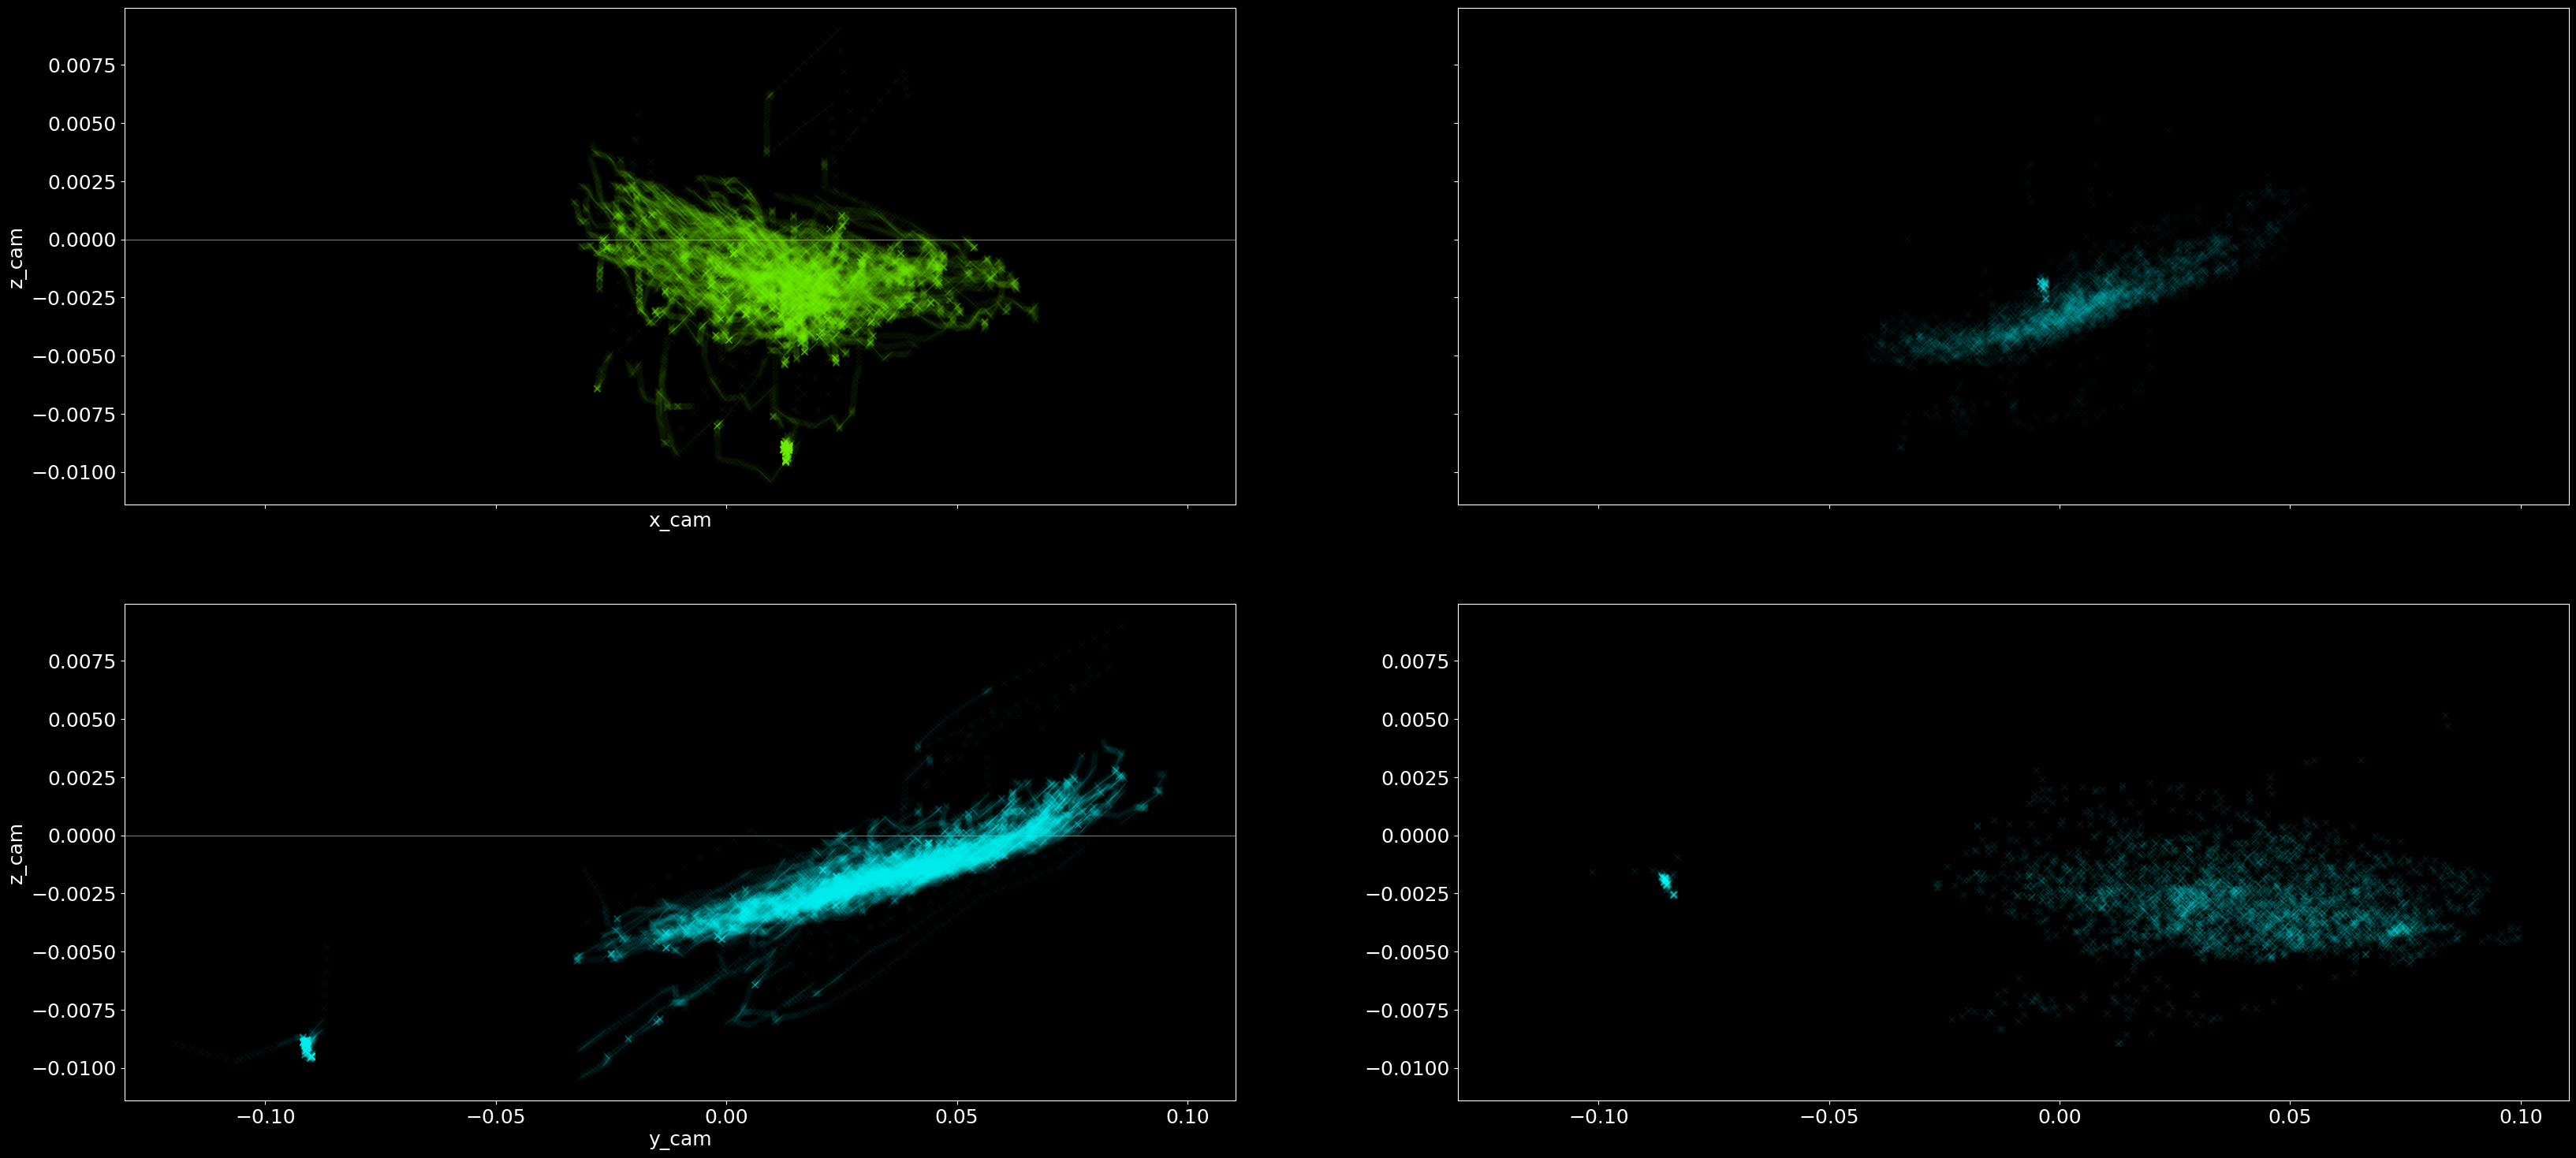

In [75]:
plt.style.use('dark_background')
fig,ax = plt.subplots(2,2,figsize=(40,18), sharex=True, sharey=True)
for trial,dat in dfs.items():
    # fig = plt.figure(figsize=(40,15))
    dat = dat["220914_f12_dlc"]
    try:
        raw_strokes_cam = dat["strokes_cam_interp"]
        strokes_cam = dat["trans_strokes_cam"]
        gaps_cam = dat["trans_gaps_cam"]
        strokes_touch = dat["strokes_touch"]
    except:
        continue
    num_strokes = len(strokes_touch)
    end_last_stroke = max(strokes_touch[-1][:,2]) + 0.5
    all_touch = np.concatenate(strokes_touch[1:-1])
    beg_first_stroke = min(all_touch[:,2])-0.5
    all_raw_cam = np.concatenate(raw_strokes_cam[1:-1])
    all_t_cam = np.concatenate(strokes_cam)

    all_pos = np.concatenate((np.concatenate(strokes_cam),np.concatenate(gaps_cam)))
    all_pos = all_pos[all_pos[:,3].argsort()]
    all_pos = all_pos[(all_pos[:,3] >= beg_first_stroke) & (all_pos[:,3] <= end_last_stroke)]

    

    
    for stroke_trans, stroke_cam in zip(strokes_cam[2:-2],raw_strokes_cam[2:-2]):
        ax[0,0].axhline(0, color='grey',linewidth=0.5,zorder=0)
        ax[1,0].axhline(0,color='grey',linewidth=0.5,zorder=0)
        ax[0,0].plot(stroke_cam[:,0],stroke_cam[:,2],'x', color='chartreuse', alpha=0.05, antialiased=False)
        ax[0,0].set_xlabel("x_cam",fontsize=18)
        ax[0,0].set_ylabel("z_cam",fontsize=18)
        ax[1,0].plot(stroke_cam[:,1],stroke_cam[:,2],'x', color='cyan',alpha=0.05, antialiased=False)
        ax[1,0].set_xlabel("y_cam",fontsize=18)
        ax[1,0].set_ylabel("z_cam",fontsize=18)
        stroke_trans_ind = [i for i in enumerate(stroke_trans)]
        ax[0,1].plot(stroke_trans[:,0],stroke_trans[:,2],'x', color='cyan',alpha=0.05, antialiased=False)
        ax[1,1].plot(stroke_trans[:,1],stroke_trans[:,2],'x', color='cyan',alpha=0.1, antialiased=False)
        ax[1,1].yaxis.set_tick_params(labelbottom=True)


    # if trial > 20:
    #     break



In [266]:
df.head(25)

,Trial,Offset,Stroke,vid on,vid off,pred on,pred off,vid on t,vid off t,pred on t,pred off t,touch on t,touch off t,pred on diff,pred off diff,touch on diff,touch off diff
0,16.0,0.358,0.0,173.5,206.5,173.93,207.21,3.828,4.488,3.8366,4.5022,3.846,4.510,0.0086,0.0142,0.018,0.022
1,19.0,0.360,0.0,165.5,196.5,165.79,196.99,3.670,4.290,3.6758,4.2998,3.682,4.310,0.0058,0.0098,0.012,0.020
2,NaN,0.360,NaN,208.5,234.0,208.98,234.16,4.530,5.040,4.5396,5.0432,4.548,5.078,0.0096,0.0032,0.018,0.038
3,20.0,0.358,0.0,173.0,198.0,173.53,197.98,3.818,4.318,3.8286,4.3176,3.830,4.330,0.0106,-0.0004,0.012,0.012
4,21.0,0.360,0.0,164.5,192.5,164.78,192.94,3.650,4.210,3.6556,4.2188,3.664,4.228,0.0056,0.0088,0.014,0.018
5,NaN,0.360,NaN,205.5,228.0,205.84,227.99,4.470,4.920,4.4768,4.9198,4.482,4.928,0.0068,-0.0002,0.012,0.008
6,22.0,0.358,0.0,166.5,188.5,165.79,188.88,3.688,4.128,3.6738,4.1356,3.680,4.142,-0.0142,0.0076,-0.008,0.014
7,NaN,0.358,NaN,201.0,217.0,201.27,217.89,4.378,4.698,4.3834,4.7158,4.398,4.726,0.0054,0.0178,0.020,0.028
8,NaN,0.358,NaN,228.5,257.0,228.15,257.50,4.928,5.498,4.9210,5.5080,4.930,5.526,-0.0070,0.0100,0.002,0.028
9,26.0,0.360,0.0,159.5,189.0,159.79,189.74,3.550,4.140,3.5558,4.1548,3.546,4.160,0.0058,0.0148,-0.004,0.020


In [76]:
trials = [16,19,20,21,22,26,30,35,45,50,150,155,156,200,374,379,390,394]
times_plot_on = []
for trial, val in onset_pts.items():
    if trial in trials:
        for v in val[1:-1]:
            times_plot_on.append(v)

#Unlabelled guys in hand chcked data
print(len(times_plot_on))
times_plot_on.pop(36)
times_plot_on.pop(35)
times_plot_on.pop(34)
times_plot_on.pop(22)

times_plot_off = []
for trial, val in offset_pts.items():
    if trial in trials:
        for v in val[1:-1]:
            times_plot_off.append(v)
print(len(times_plot_off))

times_plot_off.pop(36)
times_plot_off.pop(35)
times_plot_off.pop(22)


50
49


5.838769633507853

In [75]:
for i,j in zip(df['vid off t'], times_plot_off):
    print(i,j)

4.488 4.669846659527449
4.29 4.785855267476206
5.04 5.145293428806345
4.318 4.461647301194891
4.21 4.6957197703623965
4.92 5.0468098313598855
4.128 5.028750771827005
4.698 5.329431494485959
5.498 5.747737241178186
4.14 4.815879034887512
4.92 5.190046625366808
4.39 4.989645420209294
5.32 5.455754970939125
4.068 5.010917449528578
4.968 5.461818102499965
5.688 5.828495984548925
4.338 5.369696566299265
4.908 5.632438756365586
6.078 6.262712677566336
4.14 5.0230628272251305
4.7 5.321701496994018
5.18 5.557251308900524
4.214 4.641509940044178
4.814 4.919334174818555
3.938 4.388660528958821
4.588 4.719542350184131
4.31 5.922930785632278
4.71 6.10999104278442
5.28 6.3988962451801035
5.9 6.683054617024767
6.6 7.025484172543875
4.37 5.8877983517397645
5.1 6.264579272477694
4.814 5.670302613850714
8.732 9.776733846861653
9.592 10.205057591623037
10.212 10.532222905211086
3.836 4.810659524845589
4.236 5.003227459577967
4.836 5.330291184566525
5.576 5.691624280624829
4.274 5.910596929109584
4.824 6

<Axes: >

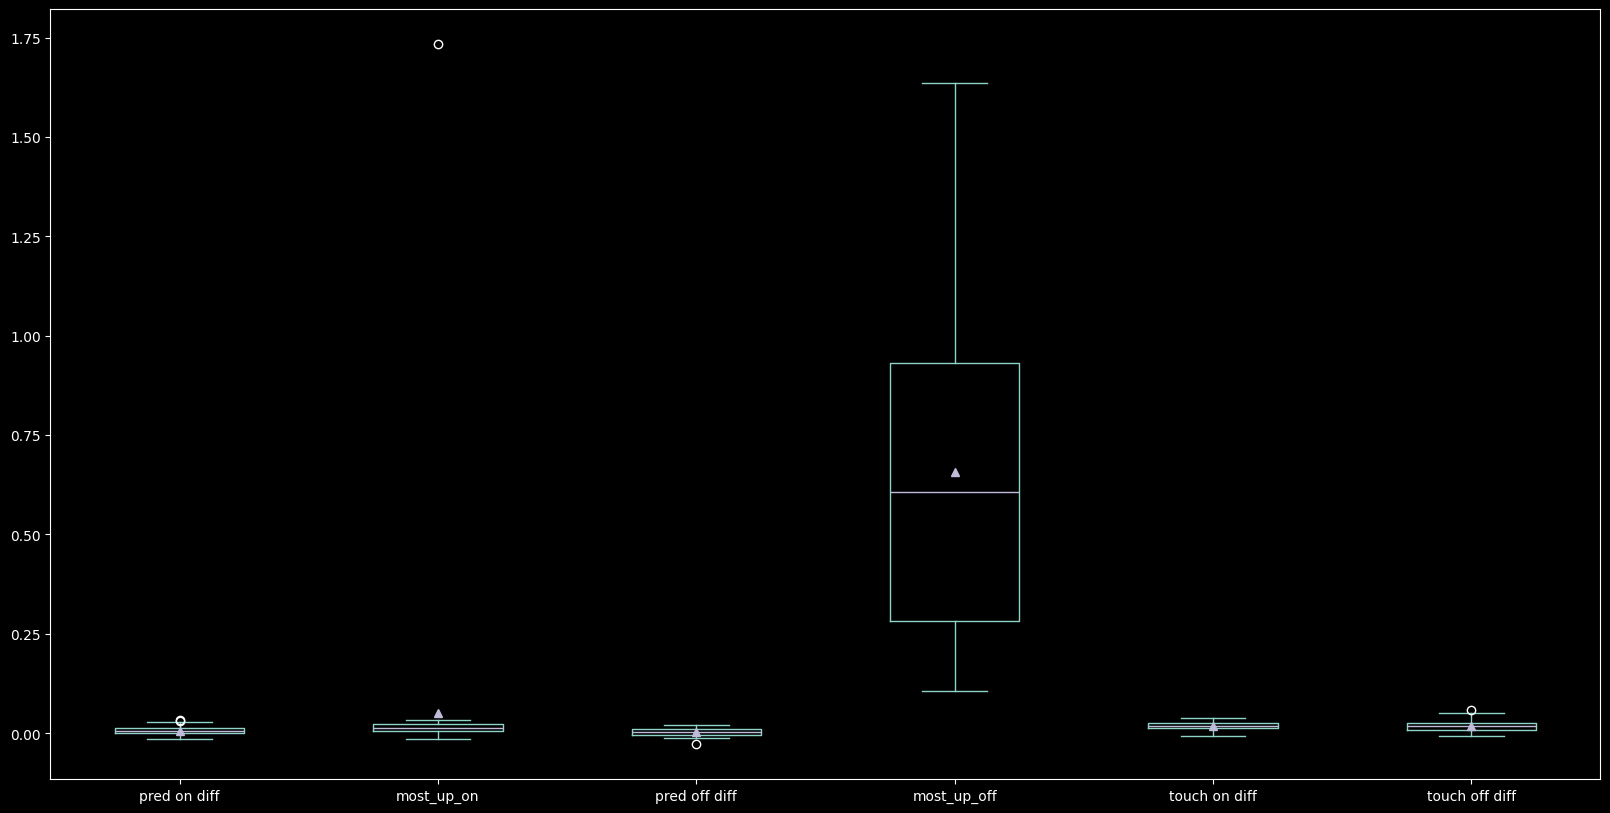

In [73]:
#Make plots of on off diffs for each type
with open('/home/danhan/Downloads/on_off_tracking - Pancho.csv', 'r') as f:
    df = pd.read_csv(f)
df['most_up_on'] = times_plot_on - df['vid on t']
df['most_up_off'] = times_plot_off - df['vid off t']
plot_list = ['pred on diff', 'most_up_on', 'pred off diff', 'most_up_off', 'touch on diff', 'touch off diff']
df[plot_list].plot(kind='box',showmeans=True, figsize=(20,10))